In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup constant head boundary with two observations

In [6]:
from morpheus.project.types.boundaries.Observation import ObservationName
from morpheus.project.types.boundaries.GeneralHeadObservation import ObservationId, GeneralHeadRawDataItem, \
  GeneralHeadObservation, Stage, Conductance
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.project.types.layers import LayerId
from morpheus.project.types.boundaries.Boundary import GeneralHeadBoundary

layers_list = [LayerId.new()]

general_head_east = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.966)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
      ]
    ),
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.964)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(200),
          conductance=Conductance.from_float(200),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(200),
          conductance=Conductance.from_float(200),
        ),
      ]
    ),
  ]
)

general_head_west = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96599)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(300),
          conductance=Conductance.from_float(300),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(300),
          conductance=Conductance.from_float(300),
        ),
      ]
    ),
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96401)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(400),
          conductance=Conductance.from_float(400),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(400),
          conductance=Conductance.from_float(400),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(general_head_west)
boundary_collection.add_boundary(general_head_east)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(general_head_east.as_geojson()))
m.add_child(folium.GeoJson(general_head_east.affected_cells.to_geojson(grid).as_geojson()))
for observation in general_head_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(general_head_west.as_geojson()))
m.add_child(folium.GeoJson(general_head_west.affected_cells.to_geojson(grid).as_geojson()))
for observation in general_head_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [7]:
general_head_east.observations

[GeneralHeadObservation(observation_id=ObservationId(value='a3940e37-dcc3-424c-a965-f748a09d0616'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92499, 50.966), type='Point'), data=[GeneralHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), stage=Stage(value=100), conductance=Conductance(value=100)), GeneralHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0, tzinfo=datetime.timezone.utc)), stage=Stage(value=100), conductance=Conductance(value=100))]),
 GeneralHeadObservation(observation_id=ObservationId(value='193dcbd3-86eb-49b7-afd7-6eb6cc964bc8'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92499, 50.964), type='Point'), data=[GeneralHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), stage=Stage(value=200), conductance=Conductance(v

In [8]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.GhbPackageMapper import \
  calculate_ghb_boundary_stress_period_data

result = calculate_ghb_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  ghb_boundary=general_head_west,
)
result.to_dict()

{0: [[0, 0, 0, 300.5050289789967, 300.5050289789967],
  [0, 1, 0, 302.5251892522284, 302.5251892522284],
  [0, 2, 0, 304.54535126413674, 304.54535126413674],
  [0, 3, 0, 306.5655150157982, 306.5655150157982],
  [0, 4, 0, 308.5856805068539, 308.5856805068539],
  [0, 5, 0, 310.60584773730386, 310.60584773730386],
  [0, 6, 0, 312.62601670750695, 312.62601670750695],
  [0, 7, 0, 314.6461874167454, 314.6461874167454],
  [0, 8, 0, 316.66635986573704, 316.66635986573704],
  [0, 9, 0, 318.68653405412294, 318.68653405412294],
  [0, 10, 0, 320.70670998226194, 320.70670998226194],
  [0, 11, 0, 322.72688764979523, 322.72688764979523],
  [0, 12, 0, 324.7470670563639, 324.7470670563639],
  [0, 13, 0, 326.7672482030445, 326.7672482030445],
  [0, 14, 0, 328.7874310884017, 328.7874310884017],
  [0, 15, 0, 330.80761571422977, 330.80761571422977],
  [0, 16, 0, 332.8278020790932, 332.8278020790932],
  [0, 17, 0, 334.847990182992, 334.847990182992],
  [0, 18, 0, 336.8681800270029, 336.8681800270029],
  [0,

In [9]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.GhbPackageMapper import \
  calculate_ghb_boundary_stress_period_data

result = calculate_ghb_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  ghb_boundary=general_head_east,
)
result.to_dict()

{0: [[0, 0, 99, 100.99997868936319, 100.99997868936319],
  [0, 1, 99, 102.99993735985626, 102.99993735985626],
  [0, 2, 99, 104.99989775163911, 104.99989775163911],
  [0, 3, 99, 106.99985986577755, 106.99985986577755],
  [0, 4, 99, 108.99982370191631, 108.99982370191631],
  [0, 5, 99, 110.9997892600554, 110.9997892600554],
  [0, 6, 99, 112.99975654055007, 112.99975654055007],
  [0, 7, 99, 114.99972554268979, 114.99972554268979],
  [0, 8, 99, 116.9996962671851, 116.9996962671851],
  [0, 9, 99, 118.99966871368073, 118.99966871368073],
  [0, 10, 99, 120.99964288253196, 120.99964288253196],
  [0, 11, 99, 122.9996187733835, 122.9996187733835],
  [0, 12, 99, 124.9995963858801, 124.9995963858801],
  [0, 13, 99, 126.99957572108755, 126.99957572108755],
  [0, 14, 99, 128.9995567775848, 128.9995567775848],
  [0, 15, 99, 130.99953955714815, 130.99953955714815],
  [0, 16, 99, 132.99952405835657, 132.99952405835657],
  [0, 17, 99, 134.99951028121004, 134.99951028121004],
  [0, 18, 99, 136.999498226

## Calculate

In [10]:
from morpheus.project.infrastructure.calculation.engines.base.CalculationEngineFactory import CalculationEngineFactory
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import CalculationId

calculation_id = CalculationId.new()
calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
engine = CalculationEngineFactory.create_engine(calculation_id=calculation_id, engine_type=calculation_profile.engine_type)
check_model_log = engine.preprocess(model, calculation_profile)
check_model_log.to_list()

['type,package,k,i,j,value,desc']

In [11]:
log, result = engine.run(model=model, calculation_profile=calculation_profile)

FloPy is using the following executable to run the model: ../../../../../../../src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/16 19:31:01

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/16 19:31:01
 Elapsed run time:  0.011 Seconds

  Normal termination of simulation


In [12]:
result

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['mf2005.list', 'mf2005.ghb', 'mf2005.dis', 'mf2005.nam', 'mf2005.bas', 'mf2005.lpf', 'mf2005.pcg', 'mf2005.oc', 'mf2005.hds'], flow_head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0, min_value=101.0893783569336, max_value=399.4720764160156), flow_drawdown_results=None, flow_budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0, min_value=None, max_value=None), transport_concentration_results=None, transport_budget_results=None, packages=['DIS', 'BAS6', 'GHB', 'PCG', 'LPF', 'OC'])

In [13]:
head = engine.read_flow_head(idx=0, layer=0)

In [14]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[300.518310546875, 302.4154968261719, 303.60791015625, 304.3465881347656, 304.76239013671875, 304.9309997558594, 304.9010009765625, 304.7052001953125, 304.3678894042969, 303.9070129394531, 303.3370056152344, 302.669189453125, 301.9129943847656, 301.0763854980469, 300.16619873046875, 299.1881103515625, 298.1471862792969, 297.04791259765625, 295.8941955566406, 294.689697265625, 293.4374084472656, 292.14019775390625, 290.8006896972656, 289.4212951660156, 288.0039978027344, 286.5509033203125, 285.0636901855469, 283.5440979003906, 281.99359130859375, 280.4136047363281, 278.8055114746094, 277.1702880859375, 275.5091857910156, 273.82330322265625, 272.1134033203125, 270.38031005859375, 268.625, 266.8479919433594, 265.04998779296875, 263.2318115234375, 261.3935852050781, 259.53619384765625, 257.6597900390625, 255.76499938964844, 253.85189819335938, 251.92080688476562, 249.97219848632812, 248.0059051513672, 246.02239990234375, 244.02149963378906, 242.00340270996094, 239.9680938720703, 237.9156

In [15]:
engine.read_flow_drawdown(idx=0, layer=0)

[]

In [16]:
engine.read_flow_budget(idx=0, incremental=False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 51283.92,
 'TOTAL_IN': 51283.92,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -51283.914,
 'TOTAL_OUT': -51283.914,
 'IN-OUT': 0.0078125,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [17]:
engine.read_flow_budget(idx=0, incremental=True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 140.5039,
 'TOTAL_IN': 140.5039,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -140.5039,
 'TOTAL_OUT': -140.5039,
 'IN-OUT': 1.5259e-05,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

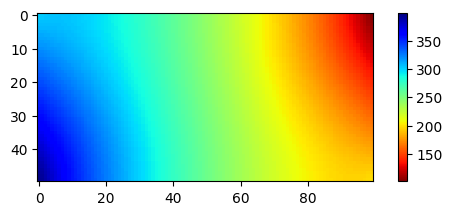

In [18]:
import matplotlib.pyplot as plt

heads = engine.read_flow_head(idx=0, layer=0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()